# **Product Review Sentiment Analysis** #

The goal of this project is to analyse customer reviews to determine their sentiment (positive, negative or neutral) based on the text content of the reviews and associated metadata. This will help understand customer feedback, identify product strengths and weaknesses and improve the overall customer experience by offering actionable insights.

**Problem Statement**: E-commerce platforms collect millions of product reviews from customers daily. However, manually analysing this vast amount of data to understand customer sentiment is inefficient. This project aims to automate sentiment analysis using machine learning and natural language processing techniques, identifying positive and negative sentiments in customer reviews to provide valuable insights for product improvement.

### **Key Steps in the Project** ###
- **Data Collection**: Utilise the provided dataset containing customer reviews and metadata.
- **Data Preprocessing**: Handle missing values, remove noise and standardise text in the 'review_body' and 'review_headline' columns.
- **Sentiment Labeling**: Use the 'star_rating' column to create sentiment labels (e.g., 1-2 stars as negative, 3 stars as neutral, 4-5 stars as positive).
- **Exploratory Data Analysis (EDA)**: Analyse sentiment distribution across different product categories and star ratings.
- **Text Processing**: Tokenise, remove stopwords and apply techniques like TF-IDF or word embeddings to transform text into numerical features.
- **Model Selection/Model Training**: Train a machine learning model (e.g., logistic regression, random forest or neural networks) to classify review sentiment.
- **Model Evaluation**: Evaluate the model using metrics such as accuracy, precision, recall and F1 score.
- **Model Deployment**: Implement the trained model in an application or API for real-time sentiment analysis.
- **Visualisation**: Generate visual insights from the sentiment analysis, highlighting patterns in customer feedback.
- **Business Insights and Recommendations**: Offer actionable recommendations to improve product offerings and customer satisfaction based on sentiment trends.


### **Step 1: Importing Required Libraries** ###

In [93]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec

# If using NLTK for text preprocessing
nltk.download('stopwords')
nltk.download('punkt')

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

### **Step 2: Data Collection** ###

In [63]:
# Load the dataset with the correct delimiter
file_path = r"C:\Users\USER\Downloads\Sentiment Analysis for Product Reviews\Amazon Product Review.txt"
data = pd.read_csv(file_path, delimiter=",", encoding="utf-8")  # Use comma as delimiter

# Preview the dataset
print(data.head())

  marketplace  customer_id       review_id  product_id  product_parent  \
0          US     11555559  R1QXC7AHHJBQ3O  B00IKPX4GY         2693241   
1          US     31469372  R175VSRV6ZETOP  B00IKPYKWG         2693241   
2          US     26843895  R2HRFF78MWGY19  B00IKPW0UA         2693241   
3          US     19844868   R8Q39WPKYVSTX  B00LCHSHMS         2693241   
4          US      1189852  R3RL4C8YP2ZCJL  B00IKPZ5V6         2693241   

                           product_title product_category  star_rating  \
0  Fire HD 7, 7" HD Display, Wi-Fi, 8 GB               PC            5   
1  Fire HD 7, 7" HD Display, Wi-Fi, 8 GB               PC            3   
2  Fire HD 7, 7" HD Display, Wi-Fi, 8 GB               PC            5   
3  Fire HD 7, 7" HD Display, Wi-Fi, 8 GB               PC            4   
4  Fire HD 7, 7" HD Display, Wi-Fi, 8 GB               PC            5   

   helpful_votes  total_votes vine verified_purchase  \
0              0            0    N                 Y  

### **Step 3 - Data Preprocessing** ###

In [64]:
# Check the columns in the dataset
print(data.columns)

Index(['marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'product_category', 'star_rating',
       'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
       'review_headline', 'review_body', 'review_date', 'sentiment'],
      dtype='object')


In [65]:
# Drop rows with missing values in 'review_headline' or 'review_body'
data.dropna(subset=['review_headline', 'review_body'], inplace=True)

# Function to clean text data
import re
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already downloaded
nltk.download('stopwords')

# Clean text function
def clean_text(text):
    # Remove punctuation, numbers, and special characters
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply the clean_text function to 'review_headline' and 'review_body'
data['review_headline'] = data['review_headline'].apply(clean_text)
data['review_body'] = data['review_body'].apply(clean_text)

# Preview cleaned dataset
print(data[['review_headline', 'review_body']].head())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                     review_headline  \
0                                         five stars   
1  lots ads slow processing speed occasionally sh...   
2                                well thought device   
3  appsgames looking forward using compatible tab...   
4                                         five stars   

                                         review_body  
0                                         great love  
1  lots adsbr slow processing speedbr occasionall...  
2  excellent unit versatility tablet besides comp...  
3  bought amazon prime ended buying gb one camera...  
4         amazon products continue meet expectations  


### **Step 4 - Sentiment Labelling** ###

In [70]:
# Function to label sentiment based on star rating
def label_sentiment(star_rating):
    if star_rating in [1, 2]:
        return 'negative'
    elif star_rating == 3:
        return 'neutral'
    elif star_rating in [4, 5]:
        return 'positive'

# Apply the label_sentiment function to create a new column 'sentiment_label'
data['sentiment_label'] = data['star_rating'].apply(label_sentiment)

# Preview the dataset with sentiment labels
print(data[['star_rating', 'sentiment_label']].head())

   star_rating sentiment_label
0            5        positive
1            3         neutral
2            5        positive
3            4        positive
4            5        positive


### **Step 5 - Exploratory Data Analysis (EDA)** ###

<Figure size 1600x700 with 0 Axes>

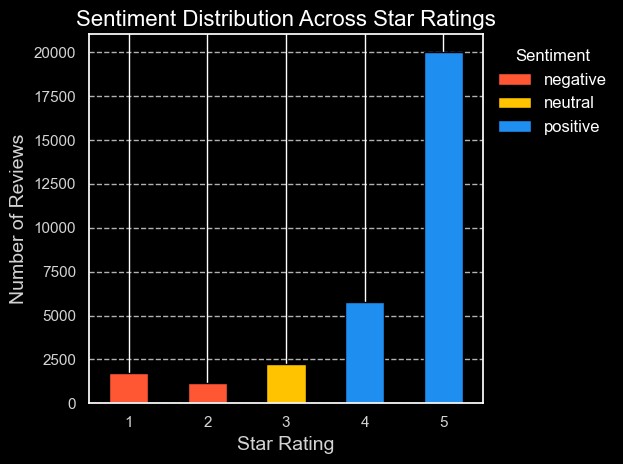

In [75]:
# 1. Sentiment Distribution Across Star Ratings

# Set a style with a dark background
plt.style.use('dark_background')

# Count the sentiment labels for each star rating
sentiment_counts_by_rating = data.groupby('star_rating')['sentiment_label'].value_counts().unstack().fillna(0)

# Plot the distribution of sentiment across star ratings
plt.figure(figsize=(16, 7))
sentiment_counts_by_rating.plot(kind='bar', stacked=True, color=['#FF5733', '#FFC300', '#1F8EF1'], edgecolor='black')
plt.title('Sentiment Distribution Across Star Ratings', fontsize=16, color='white')
plt.xlabel('Star Rating', fontsize=14, color='lightgray')
plt.ylabel('Number of Reviews', fontsize=14, color='lightgray')
plt.xticks(rotation=0, color='lightgray')
plt.yticks(color='lightgray')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Sentiment', fontsize=12, bbox_to_anchor=(1, 1), loc='upper left', frameon=False)
plt.tight_layout()
plt.show()


<Figure size 1800x800 with 0 Axes>

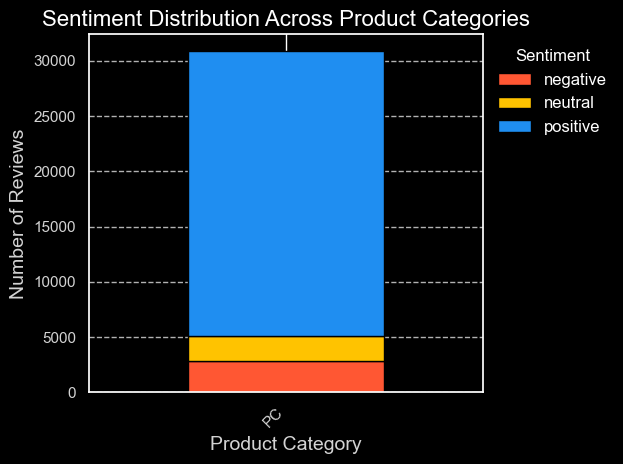

In [76]:
# 2. Sentiment Distribution Across Product Categories

# Set a style with a dark background
plt.style.use('dark_background')

# Count the sentiment labels for each product category
sentiment_counts_by_category = data.groupby('product_category')['sentiment_label'].value_counts().unstack().fillna(0)

# Plot the distribution of sentiment across product categories
plt.figure(figsize=(18, 8))
sentiment_counts_by_category.plot(kind='bar', stacked=True, color=['#FF5733', '#FFC300', '#1F8EF1'], edgecolor='black')
plt.title('Sentiment Distribution Across Product Categories', fontsize=16, color='white')
plt.xlabel('Product Category', fontsize=14, color='lightgray')
plt.ylabel('Number of Reviews', fontsize=14, color='lightgray')
plt.xticks(rotation=45, ha='right', color='lightgray')
plt.yticks(color='lightgray')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Sentiment', fontsize=12, bbox_to_anchor=(1, 1), loc='upper left', frameon=False)
plt.tight_layout()
plt.show()

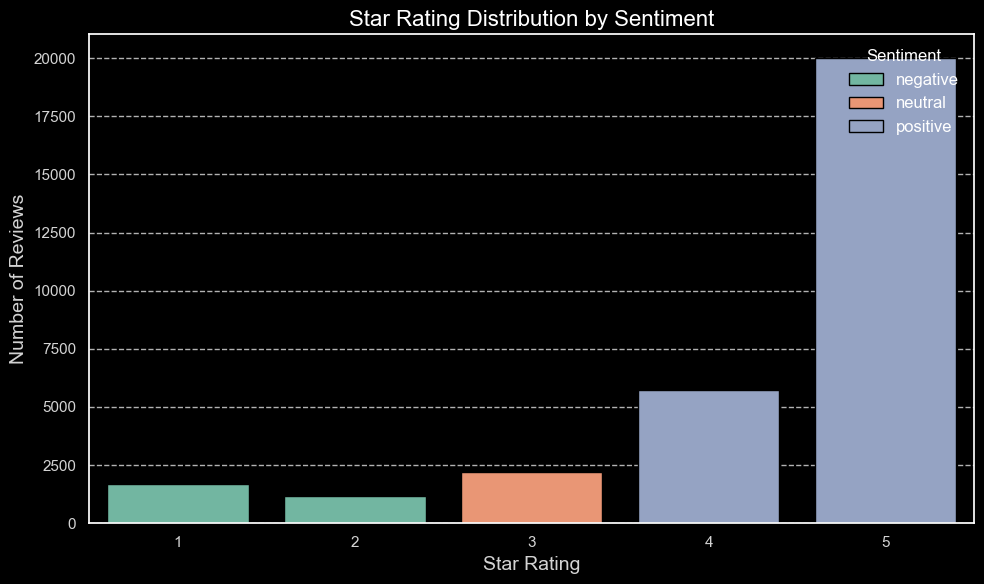

In [77]:
# 3. Star Rating Distribution by Sentiment

# Set a style with a dark background
plt.style.use('dark_background')

# Create a countplot for star ratings by sentiment label
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='star_rating', hue='sentiment_label', palette='Set2', edgecolor='black')
plt.title('Star Rating Distribution by Sentiment', fontsize=16, color='white')
plt.xlabel('Star Rating', fontsize=14, color='lightgray')
plt.ylabel('Number of Reviews', fontsize=14, color='lightgray')
plt.xticks(rotation=0, color='lightgray')
plt.yticks(color='lightgray')
plt.legend(title='Sentiment', fontsize=12, loc='upper right', frameon=False)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [80]:
# Function to clean the text
def clean_text(text):
    # Remove HTML tags and special characters
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    text = text.lower()  # Convert to lowercase
    text = ' '.join(word for word in text.split() if word not in stopwords.words('english'))  # Remove stopwords
    return text

# Apply the cleaning function to the review_body
data['cleaned_review_body'] = data['review_body'].apply(clean_text)

# Preview the cleaned review body
print(data[['review_body', 'cleaned_review_body']].head())

                                         review_body  \
0                                         great love   
1  lots adsbr slow processing speedbr occasionall...   
2  excellent unit versatility tablet besides comp...   
3  bought amazon prime ended buying gb one camera...   
4         amazon products continue meet expectations   

                                 cleaned_review_body  
0                                         great love  
1  lots adsbr slow processing speedbr occasionall...  
2  excellent unit versatility tablet besides comp...  
3  bought amazon prime ended buying gb one camera...  
4         amazon products continue meet expectations  


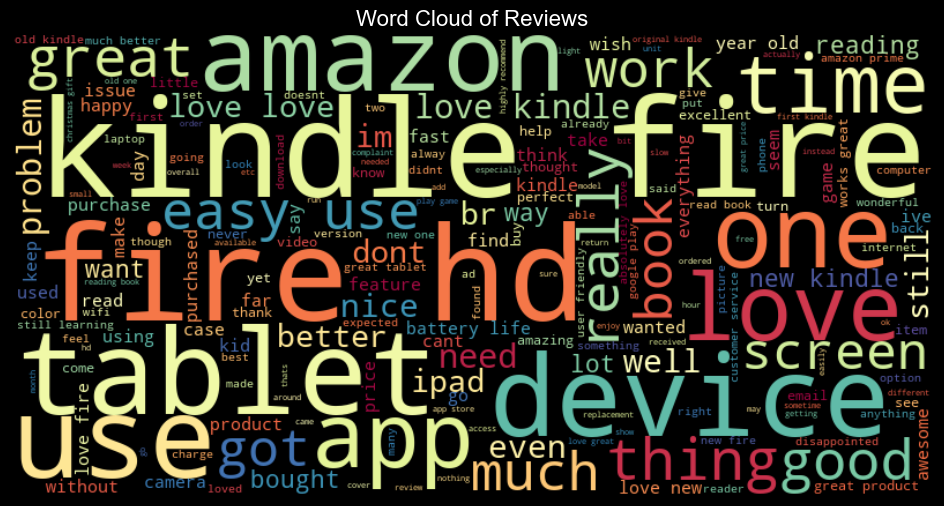

In [81]:
# 4. Perform Basic Text Analysis - Word Cloud

# Combine all cleaned reviews into a single string
all_reviews = ' '.join(data['cleaned_review_body'])

# Generate a word cloud with a unique color scheme
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='black',
    colormap='Spectral',
    contour_color='white',
    contour_width=1,
    random_state=42  # Ensures reproducibility
).generate(all_reviews)

# Display the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.title('Word Cloud of Reviews', fontsize=16, color='white')
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_16024\646649213.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=common_words_df, palette='magma')


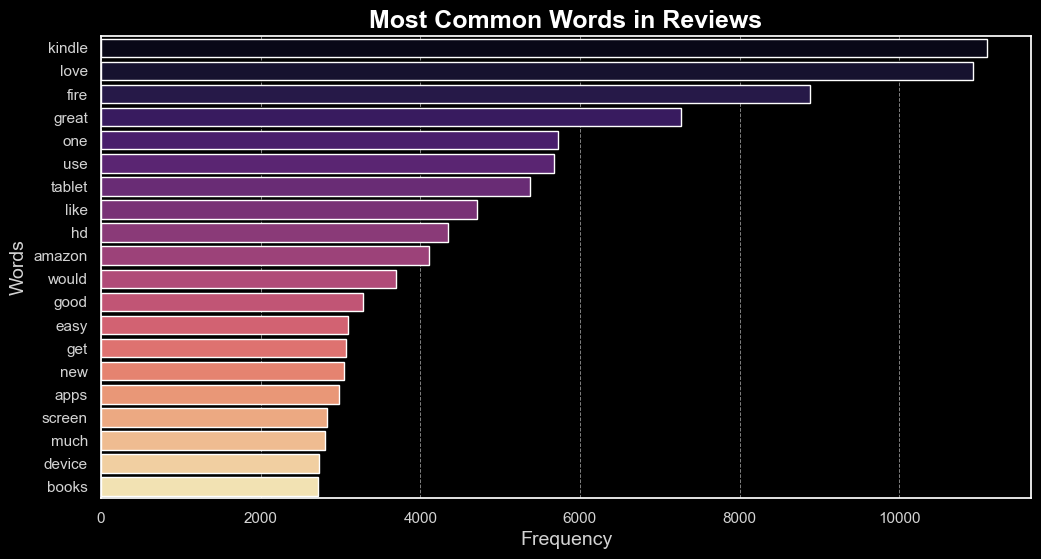

In [82]:
# 5. Most Common Words

# Tokenise the cleaned review body
all_words = ' '.join(data['cleaned_review_body']).split()

# Count the frequency of each word
word_counts = Counter(all_words)

# Get the most common words (e.g., top 20)
most_common_words = word_counts.most_common(20)

# Create a DataFrame from the most common words
common_words_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])

# Plot the most common words with a vibrant color palette and custom styling
plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Word', data=common_words_df, palette='magma')
plt.title('Most Common Words in Reviews', fontsize=18, fontweight='bold', color='white')
plt.xlabel('Frequency', fontsize=14, color='lightgray')
plt.ylabel('Words', fontsize=14, color='lightgray')
plt.grid(axis='x', color='gray', linestyle='--', linewidth=0.7)
plt.xticks(color='lightgray')
plt.yticks(color='lightgray')
plt.gca().set_facecolor('black')  # Set the background color to black
plt.show()

### **Step 6: Feature Extraction and Text Processing** ###

In [86]:
# Check the columns in your DataFrame
print(data.columns)

# Make sure to apply the cleaning function if not done already
data['cleaned_review_body'] = data['review_body'].apply(clean_text)

Index(['marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'product_category', 'star_rating',
       'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
       'review_headline', 'review_body', 'review_date', 'sentiment',
       'sentiment_label', 'cleaned_review_body'],
      dtype='object')


In [87]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [91]:
# Download NLTK resources (if not already done)
nltk.download('punkt')
nltk.download('stopwords')

# Load your dataset (adjust sep based on your file's structure)
data = pd.read_csv(r"C:\Users\USER\Downloads\Sentiment Analysis for Product Reviews\Amazon Product Review.txt", sep="\t", header=None, names=['review_body'])

# Function for text preprocessing
def preprocess_text(text):
    # Tokenize
    tokens = word_tokenize(text.lower())
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return tokens

# Apply preprocessing to your text column
data['processed_reviews'] = data['review_body'].apply(preprocess_text)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)
tfidf_matrix = tfidf_vectorizer.fit_transform(data['processed_reviews'])

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=data['processed_reviews'], vector_size=100, window=5, min_count=1, workers=4)

# Function to create feature vectors using Word2Vec
def vectorize_review(review):
    word_vectors = [word2vec_model.wv[word] for word in review if word in word2vec_model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(word2vec_model.vector_size)

# Apply vectorization
data['word2vec_vectors'] = data['processed_reviews'].apply(vectorize_review)

# Output the processed DataFrame
print(data[['review_body', 'processed_reviews', 'word2vec_vectors']].head())

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

### **Step 6: Sentiment Analysis Preparation** ###

In [16]:
import sklearn
print(sklearn.__version__)

1.5.2


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Feature Extraction using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Limit to 5000 features for simplicity
X = vectorizer.fit_transform(data['cleaned_review_body'])

# 2. Prepare target variable
y = data['star_rating']

# 3. Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting datasets
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (24673, 5000)
Testing data shape: (6169, 5000)


### **Step 5: Train a Model** ###

In [18]:
from sklearn.linear_model import LogisticRegression

# Initialise the Logistic Regression model
model = LogisticRegression(max_iter=1000)

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model's performance
from sklearn.metrics import classification_report, accuracy_score

# Print the accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")

# Print the classification report
print(classification_report(y_test, y_pred))


Accuracy: 72.91%
              precision    recall  f1-score   support

           1       0.56      0.52      0.54       327
           2       0.35      0.08      0.13       219
           3       0.36      0.25      0.29       410
           4       0.51      0.34      0.41      1193
           5       0.80      0.95      0.87      4020

    accuracy                           0.73      6169
   macro avg       0.51      0.43      0.45      6169
weighted avg       0.69      0.73      0.70      6169



### **Step 6: Evaluating the Model and Making Predictions** ###

In [19]:
# 1. Evaluate Model Performance on the Test Data

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Evaluate the model on the test set
predictions = model.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Display detailed classification metrics
print("\nClassification Report:")
print(classification_report(y_test, predictions))

# Display confusion matrix for a visual understanding of the model's performance
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, predictions))

Model Accuracy: 72.91%

Classification Report:
              precision    recall  f1-score   support

           1       0.56      0.52      0.54       327
           2       0.35      0.08      0.13       219
           3       0.36      0.25      0.29       410
           4       0.51      0.34      0.41      1193
           5       0.80      0.95      0.87      4020

    accuracy                           0.73      6169
   macro avg       0.51      0.43      0.45      6169
weighted avg       0.69      0.73      0.70      6169


Confusion Matrix:
[[ 171   13   39   32   72]
 [  56   17   64   35   47]
 [  40   14  102  135  119]
 [  23    4   68  402  696]
 [  18    1   12  183 3806]]


In [20]:
# 2. Test the Model with New Review Texts

# Define a new review
new_reviews = ["The product was amazing and worked perfectly!", 
               "Terrible experience, the product broke after two days!", 
               "It's okay, not the best, but does the job."]

# Convert the new review to the same format as the training data (vectorized form)
new_reviews_vectorized = vectorizer.transform(new_reviews)

# Use the trained model to predict the sentiments
predictions = model.predict(new_reviews_vectorized)

# Map the predicted ratings to sentiments (optional)
rating_to_sentiment = {1: 'Very Negative', 2: 'Negative', 3: 'Neutral', 4: 'Positive', 5: 'Very Positive'}
predicted_sentiments = [rating_to_sentiment[rating] for rating in predictions]

# Display the results
for review, sentiment in zip(new_reviews, predicted_sentiments):
    print(f"Review: {review}\nPredicted Sentiment: {sentiment}\n")

Review: The product was amazing and worked perfectly!
Predicted Sentiment: Very Positive

Review: Terrible experience, the product broke after two days!
Predicted Sentiment: Very Negative

Review: It's okay, not the best, but does the job.
Predicted Sentiment: Neutral



In [21]:
# 3. Save the Trained Model

import joblib

# Save the model to a file
joblib.dump(model, 'sentiment_analysis_model.pkl')

# Save the vectorizer as well (since it's needed to process new data)
joblib.dump(vectorizer, 'vectorizer.pkl')

['vectorizer.pkl']

In [22]:
# Load the model and vectorizer
model = joblib.load('sentiment_analysis_model.pkl')
vectorizer = joblib.load('vectorizer.pkl')